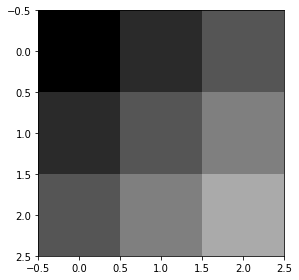

In [1]:
%matplotlib inline

from numpy import ogrid, repeat, newaxis

from skimage import io

# Generate image that will be used for test upsampling
# Number of channels is 3 -- we also treat the number of
# samples like the number of classes, because later on
# that will be used to upsample predictions from the network
imsize = 3
x, y = ogrid[:imsize, :imsize]
img = repeat((x + y)[..., newaxis], 3, 2) / float(imsize + imsize)
io.imshow(img, interpolation='none')

In [30]:
from __future__ import division
import numpy as np
import tensorflow as tf


def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    print(f"upsample_kernel.shape: {upsample_kernel.shape}")
    print(upsample_kernel)
    
    for i in range(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights


def upsample_tf(factor, input_img):
    
    number_of_classes = input_img.shape[2]
    print(f"number_of_classes: {number_of_classes}")
    
    new_height = input_img.shape[0] * factor
    new_width = input_img.shape[1] * factor
    
    print(f"img.shape: {img.shape}")
    expanded_img = np.expand_dims(input_img, axis=0)
    print(f"expanded_img.shape: {expanded_img.shape}")

    with tf.Graph().as_default():
        with tf.Session() as sess:
            with tf.device("/cpu:0"):

                upsample_filt_pl = tf.placeholder(tf.float32)
                logits_pl = tf.placeholder(tf.float32)

                upsample_filter_np = bilinear_upsample_weights(factor,
                                        number_of_classes)
                
                print(f"upsample_filter_np.shape: {upsample_filter_np.shape}")
                #print(upsample_filter_np)

                res = tf.nn.conv2d_transpose(logits_pl, upsample_filt_pl,
                        output_shape=[1, new_height, new_width, number_of_classes],
                        strides=[1, factor, factor, 1])

                final_result = sess.run(res,
                                feed_dict={upsample_filt_pl: upsample_filter_np,
                                           logits_pl: expanded_img})
    
    return final_result.squeeze()

#upsampled_img_tf = upsample_tf(factor=3, input_img=img)
#io.imshow(upsampled_img_tf)

#uk = upsample_filt(16)
#print(f"uk.shape: {uk.shape}")
#print(uk)
w = bilinear_upsample_weights(4, 6)
print(w.shape)
print(w[0,0,:,:])
print(w[0,1,:,:])
print(w[1,0,:,:])
print(w[1,1,:,:])

print(w[0,2,:,:])
print(w[0,3,:,:])

print(w[7,2,:,:])
print(w[2,7,:,:])


upsample_kernel.shape: (8, 8)
[[ 0.015625  0.046875  0.078125  0.109375  0.109375  0.078125  0.046875
   0.015625]
 [ 0.046875  0.140625  0.234375  0.328125  0.328125  0.234375  0.140625
   0.046875]
 [ 0.078125  0.234375  0.390625  0.546875  0.546875  0.390625  0.234375
   0.078125]
 [ 0.109375  0.328125  0.546875  0.765625  0.765625  0.546875  0.328125
   0.109375]
 [ 0.109375  0.328125  0.546875  0.765625  0.765625  0.546875  0.328125
   0.109375]
 [ 0.078125  0.234375  0.390625  0.546875  0.546875  0.390625  0.234375
   0.078125]
 [ 0.046875  0.140625  0.234375  0.328125  0.328125  0.234375  0.140625
   0.046875]
 [ 0.015625  0.046875  0.078125  0.109375  0.109375  0.078125  0.046875
   0.015625]]
(8, 8, 6, 6)
[[ 0.015625  0.        0.        0.        0.        0.      ]
 [ 0.        0.015625  0.        0.        0.        0.      ]
 [ 0.        0.        0.015625  0.        0.        0.      ]
 [ 0.        0.        0.        0.015625  0.        0.      ]
 [ 0.        0.        0

It seems to me that the bilinear upsample weight matrix expects to have the same input/output channels. As such, it creates a diagonal matrix at each point, where the value in the diagonal is equal for each channel x channel matrix. It is symetrical an assigned like: w[0,n,:,:] = w[n,0,:,:] and that uses nth value in the first row of the kernel x kernel matrix, w[1,n,:,:] = w[n,1,:,:] and that uses the nth value of the second row of the k x k matrix, etc.

When having mismatched channels, the diagonal matrix would only get partially filled (if iterating on the smaller of the two channels, and result in an error if iterating on the larger of the two)

The takeaway is to not use this when channels are not equal. Could use to first tconv, say a 16x16x512 to 256x256x512, then use a regular conv to get the channels down to 1.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure


# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))

# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    #print(f"len(contour): {len(contour)}")
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
from skimage import measure
from PIL import Image
import numpy as np
import  matplotlib.pyplot as plt

i = Image.open('../jeff.png')
ia = np.asarray(i)

c = measure.find_contours(ia, 0.5)

fig, ax = plt.subplots()
ax.imshow(ia, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(c):
    #print(f"len(contour): {len(contour)}")
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
from PIL import ImageDraw

blank_imga = np.zeros(ia.shape)
blank_img = Image.fromarray(blank_imga)

#draw = ImageDraw.Draw(blank_img)

#print(len(c[15]))
#for n, contour in enumerate(c):
#draw.polygon(c[15], fill=128, outline=255)

fig2, ax2 = plt.subplots()
ax2.imshow(blank_img, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(c):
    #print(f"len(contour): {len(contour)}")
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=1)

ax2.axis('image')
ax2.set_xticks([])
ax2.set_yticks([])
#plt.show()
fig2.savefig('../fig.png', pad_inches=0.0, bbox_inches='tight')

In [ ]:
from skimage.morphology import label



In [ ]:
import skimage

def drawShape(img, coordinates, color):
    # In order to draw our line in red
    img = skimage.color.gray2rgb(img)

    # Make sure the coordinates are expressed as integers
    coordinates = coordinates.astype(int)

    img[coordinates[:, 0], coordinates[:, 1]] = color

    return img

blank_imga = np.zeros(ia.shape, dtype=np.uint8)
blank_img = Image.fromarray(blank_imga)

print(f"ia shape and dtype: {ia.shape}, {ia.dtype}")
print(f"blank_imga shape and dtype: {blank_imga.shape}, {blank_imga.dtype}")

iac = blank_imga
for contour in c:
    iac = drawShape(iac, contour, [255, 0, 0]) 

iaci = Image.fromarray(iac)
iaci.save('../con.png')


In [10]:
import tensorflow as tf
import numpy as np

sess = tf.InteractiveSession()

min = -5.
max = 5.

logits = np.random.rand(2,3,3) * (max-min) + min
print(logits)
logits = tf.constant(logits)

y = np.random.randint(0,2,(2,3,3)) * 1.
print(y)

sig = tf.nn.sigmoid(logits)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
mloss = tf.reduce_mean(loss)
mloss2 = tf.losses.sigmoid_cross_entropy(y, logits)
s, l, m, m2 = sess.run([sig, loss, mloss, mloss2])
print("sigmoid:")
print(s)
print("loss:")
print(l)
print("mean loss:")
print(m)
print("mean loss 2:")
print(m2)

[[[ 4.62553048 -1.88524209 -0.86667574]
  [-4.58414748  4.80840737 -4.49185142]
  [ 4.7016369  -2.97438756  0.65414041]]

 [[ 3.09954261 -3.57569137  4.63727617]
  [ 0.31048111 -1.65980541 -4.73414339]
  [ 4.4984516   2.93902933 -1.58781484]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [1. 0. 0.]]

 [[1. 1. 0.]
  [0. 1. 1.]
  [1. 1. 0.]]]
sigmoid:
[[[0.99029662 0.13178792 0.29594648]
  [0.01010921 0.99190521 0.01107584]
  [0.99100131 0.04859646 0.65794289]]

 [[0.95687387 0.02723363 0.99040884]
  [0.57700269 0.15978812 0.00871338]
  [0.98899622 0.94974242 0.16969156]]]
loss:
[[[4.63528124 0.14131926 0.3509009 ]
  [0.01016066 4.8165351  0.01113763]
  [0.00903942 0.04981698 1.07277756]]

 [[0.04408369 3.6033027  4.64691361]
  [0.86038946 1.83390659 4.74289496]
  [0.01106477 0.05156447 0.18595803]]]
mean loss:
1.504280391317079
mean loss 2:
1.5042804479599


In [1]:
import tensorflow as tf
import numpy as np

sess = tf.InteractiveSession()

min = -5.
max = 5.

logits = np.random.rand(3,3) * (max-min) + min
print(logits)
logits = tf.constant(logits)

y = np.random.randint(0,2,(3,3)) * 1.
print(y)

# Weights test
w = np.zeros((3,3))
w[y==1] = 4.
w[y==0] = 1.
print(w)
w = tf.constant(w)

sig = tf.nn.sigmoid(logits)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
mloss = tf.reduce_mean(loss)

loss_w = tf.multiply(loss, w)
mloss_w = tf.reduce_mean(loss_w)

mloss2 = tf.losses.sigmoid_cross_entropy(y, logits, weights=w)
s, l, lw, m, mw, m2 = sess.run([sig, loss, loss_w, mloss, mloss_w, mloss2])
print("sigmoid:")
print(s)
print("loss:")
print(l)
print("weighted loss:")
print(lw)
print("mean loss:")
print(m)
print("weighted mean loss:")
print(mw)
print("mean loss 2 (weighted):")
print(m2)

# TODO: test the weighted loss with batches. ie. If I output (batch_size, 256, 256) does the weight matrix need to
# be that size (a la per sample weights) or can it be (1, 256, 256) and broadcast to each sample correctly.

/home/jfaath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[[ 4.06611499 -4.88533314 -4.76440215]
 [-0.0969466  -2.79080541 -4.33087773]
 [-1.81126979  4.44489837  4.83295778]]
[[1. 1. 0.]
 [0. 1. 1.]
 [0. 0. 0.]]
[[4. 4. 1.]
 [1. 4. 4.]
 [1. 1. 1.]]
sigmoid:
[[0.98314509 0.00749993 0.00845587]
 [0.47578231 0.05782306 0.01298516]
 [0.14048473 0.98839789 0.99209997]]
loss:
[[0.01699857 4.89286134 0.00849183]
 [0.64584825 2.8503676  4.34394794]
 [0.15138669 4.45656831 4.84088918]]
weighted loss:
[[6.79942623e-02 1.95714454e+01 8.49182733e-03]
 [6.45848251e-01 1.14014704e+01 1.73757918e+01]
 [1.51386688e-01 4.45656831e+00 4.84088918e+00]]
mean loss:
2.4674844118250294
weighted mean loss:
6.502209561677726
mean loss 2 (weighted):
6.502209186553955


In [1]:
import tensorflow as tf
from tensorflow.python import pywrap_tensorflow
from tensorflow.contrib import slim
from tensorflow.contrib.slim.python.slim.nets import resnet_v1

reader = pywrap_tensorflow.NewCheckpointReader('../training-runs/init/resnet_v1_50.ckpt')
p = tf.placeholder(tf.float32, [None, 256, 256, 3])

with slim.arg_scope(resnet_v1.resnet_arg_scope()):
    m = resnet_v1.resnet_v1_50(p, is_training=True, global_pool=False)

/home/jfaath/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
v = slim.get_model_variables()
print(len(v))
vnames = [x.op.name for x in v]
for n in vnames:
    print(n)
on = v[2].op.name
print(on)
print(reader.has_tensor(on))

265
resnet_v1_50/conv1/weights
resnet_v1_50/conv1/BatchNorm/gamma
resnet_v1_50/conv1/BatchNorm/beta
resnet_v1_50/conv1/BatchNorm/moving_mean
resnet_v1_50/conv1/BatchNorm/moving_variance
resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/weights
resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/BatchNorm/gamma
resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/BatchNorm/beta
resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/BatchNorm/moving_mean
resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/BatchNorm/moving_variance
resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/weights
resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/BatchNorm/gamma
resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/BatchNorm/beta
resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/BatchNorm/moving_mean
resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/BatchNorm/moving_variance
resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/weights
resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/BatchNorm/gamma
resnet_v1_50/block1/unit_1/bottleneck

In [8]:
print(tf.trainableVariables())

AttributeError: module 'tensorflow' has no attribute 'trainableVariables'

In [15]:
params = tf.trainable_variables()
print(len(params))
#for p in params:
#    print(p.op.name)
    
params[0].trainable=False
params = tf.trainable_variables()
print(len(params))
for p in params:
    print(f"{p.op.name},{p.trainable}")


159
159
resnet_v1_50/conv1/weights,False


AttributeError: 'Variable' object has no attribute 'trainable'